In [ ]:
! pip install kaggle

In [ ]:
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [ ]:
! unzip -q skin-cancer-mnist-ham10000.zip

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image as pil_image
from IPython.display import Image as Image
from matplotlib.pyplot import imshow, imsave

np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:

main_df = pd.read_csv('HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


c:\users\nprav\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dx', ylabel='count'>

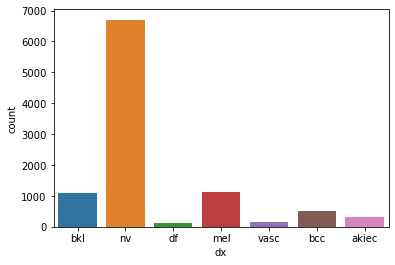

In [3]:
sns.countplot(main_df['dx'])

In [4]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

c:\users\nprav\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'scalp'),
  Text(1, 0, 'ear'),
  Text(2, 0, 'face'),
  Text(3, 0, 'back'),
  Text(4, 0, 'trunk'),
  Text(5, 0, 'chest'),
  Text(6, 0, 'upper extremity'),
  Text(7, 0, 'abdomen'),
  Text(8, 0, 'unknown'),
  Text(9, 0, 'lower extremity'),
  Text(10, 0, 'genital'),
  Text(11, 0, 'neck'),
  Text(12, 0, 'hand'),
  Text(13, 0, 'foot'),
  Text(14, 0, 'acral')])

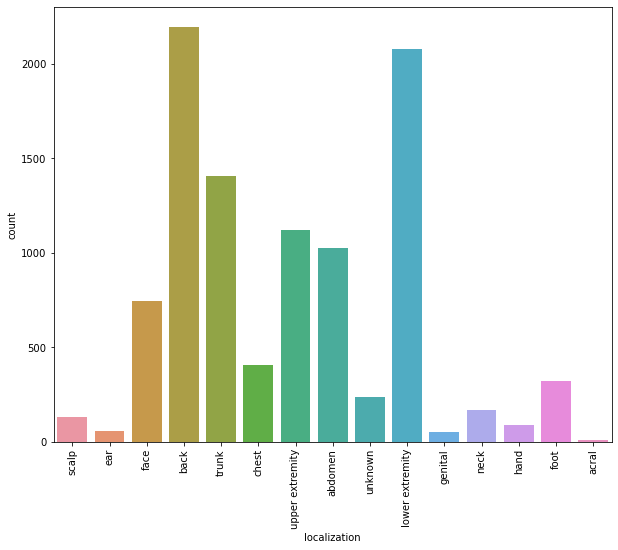

In [5]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

c:\users\nprav\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dx_type', ylabel='count'>

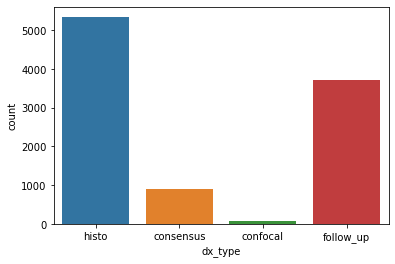

In [6]:
sns.countplot(main_df['dx_type'])

In [7]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [8]:
main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

In [9]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


<AxesSubplot:xlabel='age', ylabel='Density'>

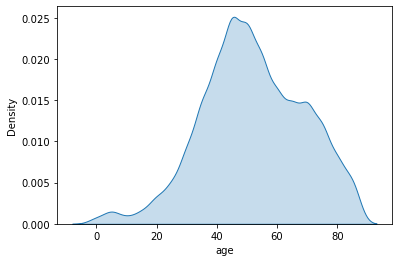

In [10]:
sns.kdeplot(main_df['age'],shade=True)

In [11]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [12]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [13]:
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

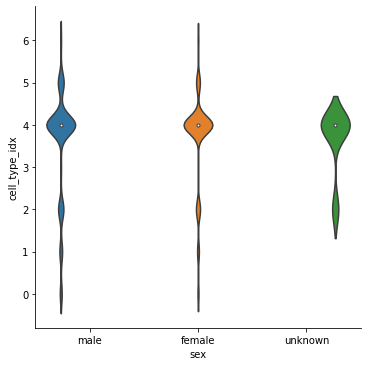

In [14]:
sns.catplot(x="sex", y="cell_type_idx",
                    hue="sex",
                    data=main_df,
                    kind="violin")

In [15]:
import os
#pil_image = os.path.join('images')
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('', '*', '*.jpg'))}

In [16]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg


In [17]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [18]:
image_example.shape

(450, 600, 3)

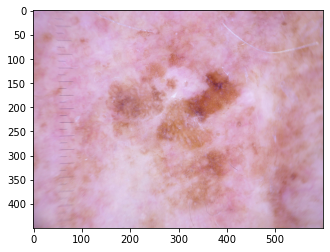

In [19]:
plt.imshow(image_example)

In [20]:
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [21]:
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg,"[[[190, 152, 194], [192, 155, 197], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 23], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg,"[[[185, 126, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025661.jpg,"[[[24, 11, 17], [25, 11, 20], [31, 16, 27], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg,"[[[131, 89, 111], [143, 98, 121], [153, 108, 1..."


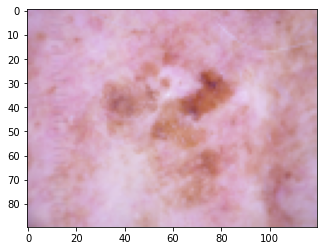

In [22]:
plt.imshow(main_df['image'][0])

In [23]:
main_df['image'][0].shape

(90, 120, 3)

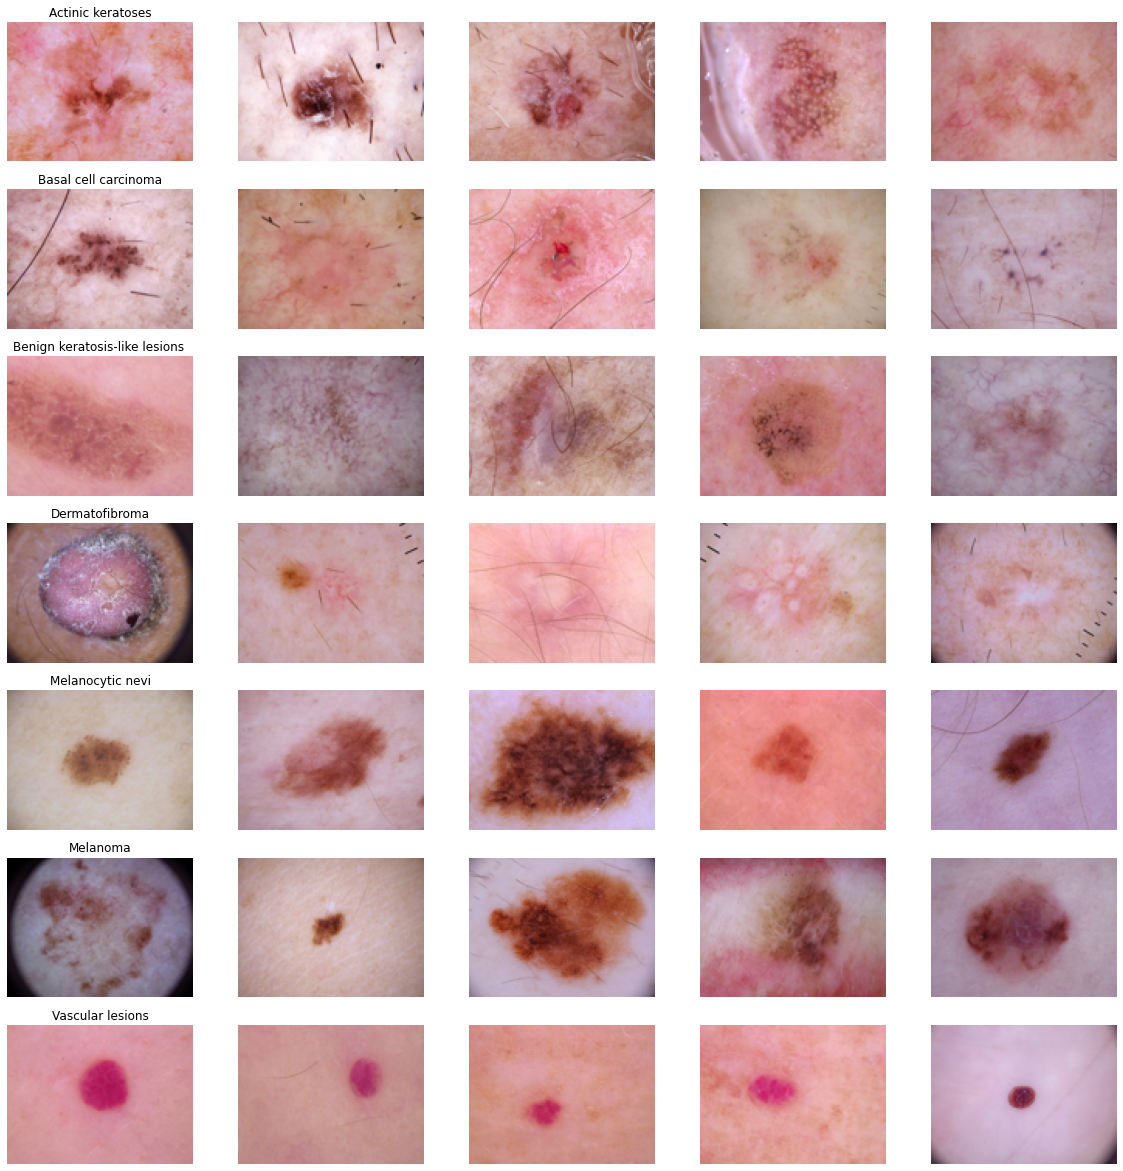

In [24]:
fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

In [25]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [26]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [27]:
print(x_train.shape)
print(x_test.shape)

(9914, 90, 120, 3)
(101, 90, 120, 3)


In [28]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train-x_train_mean) / x_train_std
x_test = (x_test-x_test_mean) / x_test_std

In [29]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [30]:
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

In [31]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [32]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [33]:
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

In [34]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


In [35]:
input_shape = (90, 120, 3)
num_classes = 7

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 120, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 120, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 30, 64)        0

In [36]:
# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [37]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 30
batch_size = 16
model.fit_generator(datagen.flow(X_train, 
                                 Y_train, 
                                 batch_size=batch_size), 
                    epochs = epochs, 
                    validation_data = (X_val,Y_val),
                    verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, 
                    callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
526/526 [==============================] - 345s 655ms/step - loss: 0.9943 - accuracy: 0.6663 - val_loss: 0.8619 - val_accuracy: 0.6969
Epoch 2/30
526/526 [==============================] - 330s 628ms/step - loss: 0.8888 - accuracy: 0.6803 - val_loss: 0.7749 - val_accuracy: 0.7097
Epoch 3/30
526/526 [==============================] - 332s 630ms/step - loss: 0.8456 - accuracy: 0.6957 - val_loss: 0.7426 - val_accuracy: 0.7184
Epoch 4/30
526/526 [==============================] - 330s 627ms/step - loss: 0.8140 - accuracy: 0.7050 - val_loss: 0.7511 - val_accuracy: 0.7332
Epoch 5/30
526/526 [==============================] - 337s 642ms/step - loss: 0.7912 - accuracy: 0.7153 - val_loss: 0.7068 - val_accuracy: 0.7305
Epoch 6/30
526/526 [==============================] - 342s 650ms/step - loss: 0.7607 - accuracy: 0.7228 - val_loss: 0.6913 - val_accuracy: 0.7339
Epoch 7/30
526/526 [============================

In [40]:
model.save('models/model_SC.h5')

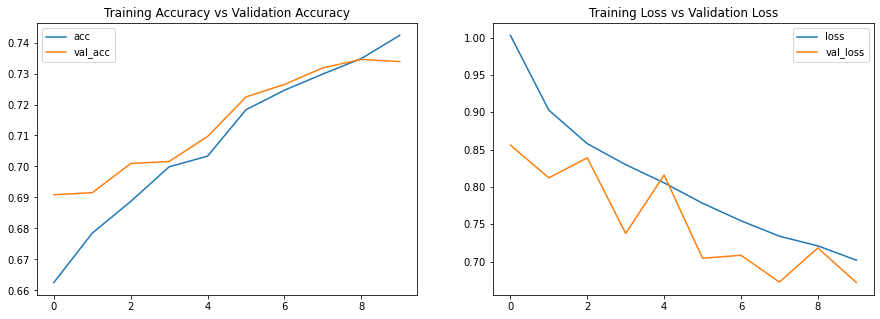

In [41]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [42]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_accuracy'])*100,4))

MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is :  73.4543
